<h1 style="text-align:center">Ch 4.3. LDA by sphering data</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

 ## 1. Fit a linear model

### 1-1. Sample estimates (Gaussian Parameters)

In [2]:
def prior_hat(N, N_k):
    return N_k/N

In [1]:
def mu_hat(x, N_k):
    return np.sum(x, axis=0)/N_k 

In [2]:
def sig(x, mu_hat):
    r,c = x.shape 
    S = (x[0,:]-mu_hat).T*(x[0,:]-mu_hat)
    for i in range(1,r):
        S += (x[i,:]-mu_hat).T*(x[i,:]-mu_hat)
    return S

### 1-2. Eigendecomposition

$$\hat{\Sigma} = UDU^T$$
$$D^{-1/2}U^T x = x^*$$
$$D^{-1/2}U^T \hat{\mu}_k =   \hat{\mu}_k^*$$

In [80]:
def eigen_decomposition(S):
    Lam, U = np.linalg.eig(S)
    D = np.diag(np.flip(1 / np.sqrt(Lam)))
    U = np.flip(U, axis=1)
    return np.matrix(D @ U.T)

### 1-3. Discrimination Function

$$\delta_k(x) = -\frac{1}{2}\lVert x^* - \hat{\mu}_k^* \rVert_2^2 + \log \pi_k$$

In [3]:
def Delta(x_trsf, sig_hat, mu_trsf, prior_hat):
    return -0.5 * np.linalg.norm(x_trsf - mu_trsf) ** 2 + np.log(prior_hat)  

In [82]:
def Deltas(x, sig_hat, mu_hats, prior_hats):
    return [Delta(x, sig_hat, mu, prior) for (mu, prior) in zip(mu_hats, prior_hats)]

In [83]:
def find_G_hat(deltas):
    return np.argmax(deltas, axis=0)

## 2. Implementation for Example
- $N = 100$
- $K = 3$
- $p=2$

::LDA assumption::
 The classes have a common covariance matrix

In [84]:
# Input variables
feature = 2
N=100
K=3

np.random.seed(15)

x1_x = np.matrix(np.random.normal(loc=0.8,scale=0.1,size=(40,1))) # loc=mean, scale=variation
x1_y = np.matrix(np.random.normal(loc=1,scale=0.4,size=(40,1)))
x1 = np.column_stack([x1_x, x1_y])

x2_x = np.matrix(np.random.normal(1.5,0.1, size=(30,1)))
x2_y = np.matrix(np.random.normal(3,0.4, size=(30,1)))
x2 = np.column_stack([x2_x, x2_y])

x3_x = np.matrix(np.random.normal(2.2,0.1, size=(30,1)))
x3_y = np.matrix(np.random.normal(0.8, 0.4, size=(30,1)))
x3 = np.column_stack([x3_x, x3_y])

In [85]:
# data size of subsets
n1,_ = x1.shape 
n2,_ = x2.shape
n3,_ = x3.shape

### 2-1. Estimated Gaussian parameters

In [86]:
xs = [x1, x2, x3]
ns = [x.shape[0] for x in xs]
prior_hats = [prior_hat(N, n) for n in ns] # estimated prior probabilities 
mu_hats_trsp = [mu_hat(x,n) for (x,n) in zip(xs, ns)] # estimated means 
sigs = [sig(x, mu) for (x, mu) in zip(xs, mu_hats_trsp)]  # sigs = sig1 + sig2 + ... + sigK
sig_hat = 1/(N-K) * np.add.reduce(sigs) # = sigs[0]+sigs[1]+sigs[2]
DU_trsp = eigen_decomposition(sig_hat).T

In [87]:
d, u = np.linalg.eig(sig_hat)

In [88]:
d

array([0.0108741 , 0.15785245])

In [89]:
sig_hat

array([[0.011092  , 0.00565504],
       [0.00565504, 0.15763454]])

In [90]:
u @ np.diag(d) @ u.T

array([[0.011092  , 0.00565504],
       [0.00565504, 0.15763454]])

In [92]:
DU_trsp

matrix([[-0.09691229, -9.58255175],
        [-2.51508214,  0.36923923]])

In [93]:
xs_trsf = [x * DU_trsp for x in xs]
mu_trsf = [mu * DU_trsp for mu in mu_hats_trsp]

In [94]:
mu_trsf

[matrix([[-2.68455642, -7.08654524]]),
 matrix([[ -7.75607097, -13.3698716 ]]),
 matrix([[ -2.0881206 , -20.58391026]])]

### 2-2. New data

In [95]:
new_x = np.matrix("1.7 1.7")
new_x_trsf = new_x * DU_trsp

In [96]:
new_x.shape

(1, 2)

In [103]:
G = find_G_hat(Deltas(new_x_trsf, sig_hat, mu_trsf, prior_hats))
print(G)
if G == 0:
    print("Cat")
elif G == 1:
    print("Dog")
else:
    print("Rabbit")

1
Dog


## 3. Plotting

In [98]:
x1 = xs_trsf[0]
x2 = xs_trsf[1]
x3 = xs_trsf[2]

In [99]:
x11 = np.asarray(x1[:,0]).ravel()
x12 = np.asarray(x1[:,1]).ravel()
x21 = np.asarray(x2[:,0]).ravel()
x22 = np.asarray(x2[:,1]).ravel()
x31 = np.asarray(x3[:,0]).ravel()
x32 = np.asarray(x3[:,1]).ravel()

(-24.0, -4.0)

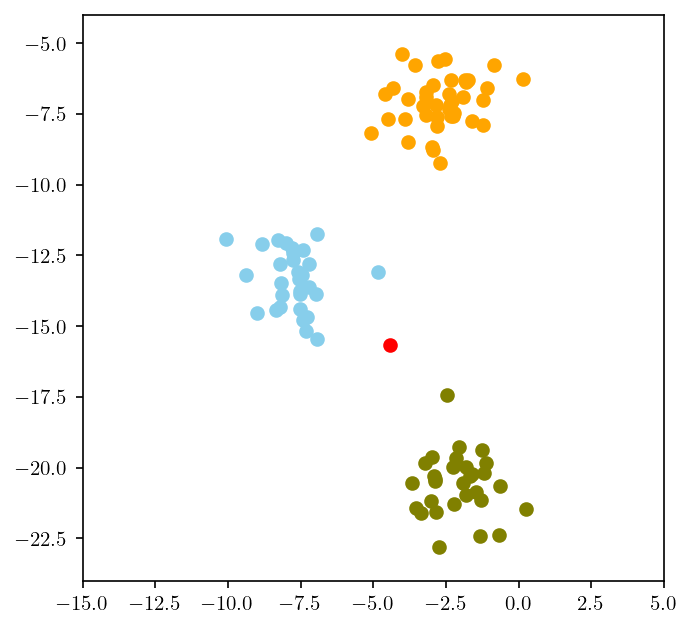

In [106]:
# Use latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Prepare Plot
plt.figure(figsize=(5,5), dpi=150)

plt.scatter(x11, x12, color="orange")
plt.scatter(x21, x22, color="skyblue")
plt.scatter(x31, x32, color="olive")
plt.scatter(new_x_trsf[0,0],new_x_trsf[0,1], color="red")

plt.xlim([-15, 5])
plt.ylim([-24, -4])

### 3-1. Decision Boundaries

In [107]:
def find_boundary(dom_trsf, mu1_trsf, mu2_trsf, N1, N2):
    a = (np.log(N2/N1) + 0.5 * (np.linalg.norm(mu1_trsf)**2 - np.linalg.norm(mu2_trsf)**2)) / (mu1_trsf[0,1] - mu2_trsf[0,1])
    b = (mu2_trsf[0,0] - mu1_trsf[0,0]) / (mu1_trsf[0,1] - mu2_trsf[0,1])
    return a + b * dom_trsf

In [123]:
domain = np.arange(-15,6) 

B12 = np.asarray(find_boundary(domain, mu_trsf[0], mu_trsf[1], n1, n2)).ravel()
B23 = np.asarray(find_boundary(domain, mu_trsf[1], mu_trsf[2], n2, n3)).ravel()
B31 = np.asarray(find_boundary(domain, mu_trsf[2], mu_trsf[0], n3, n1)).ravel()

(-24.0, -4.0)

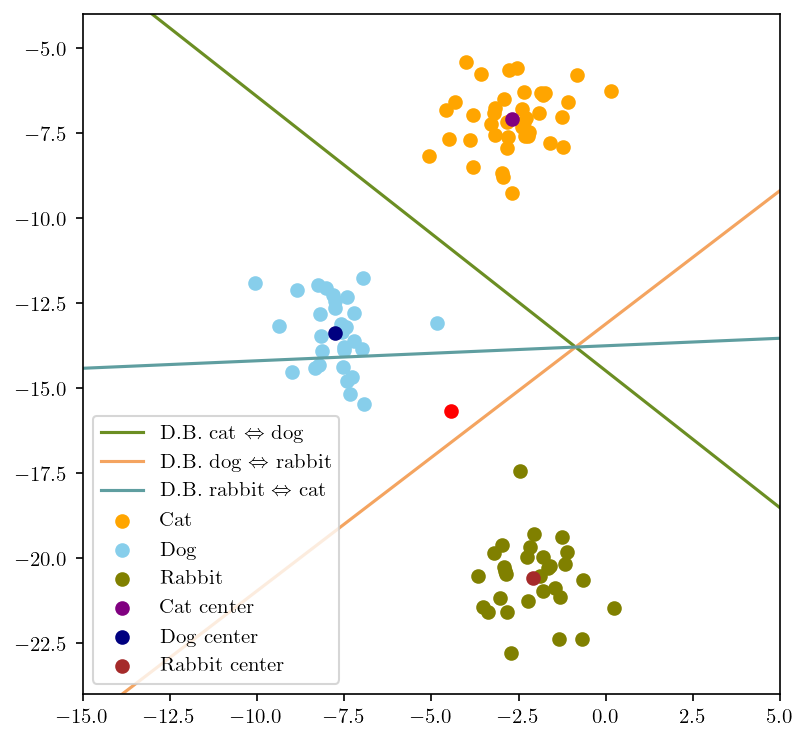

In [132]:
plt.figure(figsize=(6,6), dpi=150)

plt.scatter(x11, x12, color="orange", label="Cat")
plt.scatter(x21, x22, color="skyblue", label="Dog")
plt.scatter(x31, x32, color="olive", label="Rabbit")
plt.scatter(new_x_trsf[0,0],new_x_trsf[0,1], color="red")
plt.scatter(mu_trsf[0][0,0], mu_trsf[0][0,1], color="purple", label="Cat center")
plt.scatter(mu_trsf[1][0,0], mu_trsf[1][0,1], color="navy", label="Dog center")
plt.scatter(mu_trsf[2][0,0], mu_trsf[2][0,1], color="brown", label="Rabbit center")

plt.plot(domain, B12, color="olivedrab", label=r"D.B. cat $\Leftrightarrow$ dog")
plt.plot(domain, B23, color="sandybrown", label=r"D.B. dog $\Leftrightarrow$ rabbit")
plt.plot(domain, B31, color="cadetblue", label="D.B. rabbit $\Leftrightarrow$ cat")

plt.legend(loc="lower left")
plt.xlim([-15, 5])
plt.ylim([-24, -4])